In [1]:
!pip install -e .. > /dev/null 2>&1

In [2]:
import os
import json
import gdown
import shutil

from astrohack.gdown_utils import gdown_data
from astrohack.gdown_utils import build_folder_structure

In [3]:
# Build folder structure & download 
import astrohack

base_name = 'ea25_cal_small_'

datafolder = 'data'
resultsfolder = 'results'

build_folder_structure(datafolder, resultsfolder)

astrohack.gdown_utils.download('ea25_cal_small_before_fixed.split.ms', folder=datafolder, unpack=True)
astrohack.gdown_utils.download('ea25_cal_small_after_fixed.split.ms', folder=datafolder, unpack=True)
astrohack.gdown_utils.download(file='extract_holog_verification.json')
astrohack.gdown_utils.download(file='holog_numerical_verification.json')

In [4]:
from astrohack.astrohack_client import astrohack_local_client

log_parms = {'log_level':'DEBUG'}

client = astrohack_local_client(cores=2, memory_limit='8GB', log_parms=log_parms)

2023-05-30 09:41:57,343 - INFO     - astrohack - (_check_parms.py:130) - [_check_logger_parms]: Setting default log_to_term to True.
2023-05-30 09:41:57,344 - INFO     - astrohack - (_check_parms.py:130) - [_check_logger_parms]: Setting default log_to_file to False.
2023-05-30 09:41:57,344 - INFO     - astrohack - (_check_parms.py:130) - [_check_logger_parms]: Setting default log_file to hack_.
2023-05-30 09:41:57,345 - INFO     - astrohack - (_check_parms.py:130) - [_check_worker_logger_parms]: Setting default log_to_term to False.
2023-05-30 09:41:57,346 - INFO     - astrohack - (_check_parms.py:130) - [_check_worker_logger_parms]: Setting default log_to_file to False.
2023-05-30 09:41:57,347 - INFO     - astrohack - (_check_parms.py:130) - [_check_worker_logger_parms]: Setting default log_file to hack_.
2023-05-30 09:41:57,348 - INFO     - astrohack - (_check_parms.py:130) - [_check_worker_logger_parms]: Setting default log_level to INFO.
2023-05-30 09:41:59,634 - INFO     - astroha

In [5]:
def test_holog_obs_dictionary(holog_obs_dict):
    import os
    import json
    import copy
    
    import numpy as np

    from astrohack._utils._tools import _jsonify

    ref_holog_obj = {}
    ref_holog_obj = copy.deepcopy(holog_obs_dict)

    _jsonify(ref_holog_obj)

    with open(".holog_obs_dict.json") as json_file:
        holog_obj = json.load(json_file)
                          
    assert holog_obj == ref_holog_obj, "Error: holog_obs_descrition dictionary has changes unexpectedly."
    
def test_holog_diagnostics(cell_size, grid_size, number_of_digits=7):
    import json
    
    with open(".holog_diagnostic.json") as json_file:
        json_data = json.load(json_file)
        
    json_data['cell_size'] = [round(x, number_of_digits) for x in json_data['cell_size']]
        
    assert (json_data['cell_size'] == cell_size).all(), "Unexpected change in cell_size occured."
    assert (json_data['grid_size'] == grid_size).all(), "Unexpected change in grid_size occured."

    
def test_center_pixel(file, antenna, ddi, reference_center_pixels, number_of_digits=7):
    from astrohack.dio import open_image
    
    mds = open_image(file)[antenna][ddi]
    
    aperture_shape = mds.APERTURE.values.shape[-2], mds.APERTURE.values.shape[-1]
    beam_shape = mds.BEAM.values.shape[-2], mds.BEAM.values.shape[-1]    
    
    aperture_center_pixels = np.squeeze(mds.APERTURE.values[..., aperture_shape[0]//2, aperture_shape[1]//2])
    beam_center_pixels = np.squeeze(mds.BEAM.values[..., beam_shape[0]//2, beam_shape[1]//2])
    
    aperture_ref = list(map(complex, reference_center_pixels['aperture']))
    beam_ref = list(map(complex, reference_center_pixels['beam']))
    
    for i in range(len(aperture_ref)):
        # Should probably write a custom round function here
        assert round(aperture_ref[i].real, number_of_digits) == round(aperture_center_pixels[i].real, number_of_digits), "There has been a shift in aperture center pixel value(s)"
        assert round(beam_ref[i].real, number_of_digits) == round(beam_center_pixels[i].real, number_of_digits), "There has been a shift in beam center pixel value(s)"
    
        assert round(aperture_ref[i].imag, number_of_digits) == round(aperture_center_pixels[i].imag, number_of_digits), "There has been a shift in aperture center pixel value(s)"
        assert round(beam_ref[i].imag, number_of_digits) == round(beam_center_pixels[i].imag, number_of_digits), "There has been a shift in beam center pixel value(s)"
    
def get_center_pixel(file, antenna, ddi):
    from astrohack.dio import open_image
    
    mds = open_image(file)[antenna][ddi]
    
    aperture_shape = mds.APERTURE.values.shape[-2], mds.APERTURE.values.shape[-1]
    beam_shape = mds.BEAM.values.shape[-2], mds.BEAM.values.shape[-1]    
    
    aperture_center_pixels = mds.APERTURE.values[..., aperture_shape[0]//2, aperture_shape[1]//2]
    beam_center_pixels = mds.BEAM.values[..., beam_shape[0]//2, beam_shape[1]//2]
    
    return np.squeeze(aperture_center_pixels), np.squeeze(beam_center_pixels)

In [6]:
from astrohack.extract_holog import extract_holog
import numpy as np

beforems = datafolder+'/'+ base_name + 'before_fixed.split.ms'
beforeholog = resultsfolder+'/before.split.holog.zarr'
afterms =  datafolder+'/'+ base_name + 'after_fixed.split.ms'
afterholog = resultsfolder+'/after.split.holog.zarr'

with open("extract_holog_verification.json") as file:
    json_dict = json.load(file)
    
holog_obs_dict = json_dict["vla"]

extract_holog(
    ms_name=beforems, 
    holog_name=beforeholog, 
    ddi=[0],
    data_column='CORRECTED_DATA',
    parallel=False,
    overwrite=True,
    reuse_point_zarr=False
)

test_holog_obs_dictionary(holog_obs_dict["before"])

holog_mds_after, _ = extract_holog(
    ms_name=afterms, 
    holog_name=afterholog,
    data_column='CORRECTED_DATA',
    parallel=False,
    overwrite=True,
    reuse_point_zarr=False
)

test_holog_obs_dictionary(holog_obs_dict["after"])

2023-05-30 09:41:59,672 - INFO     - astrohack - (_check_parms.py:130) - [extract_holog]: Setting default point_name to results/before.split.point.zarr.
2023-05-30 09:41:59,673 - INFO     - astrohack - (_check_parms.py:130) - [extract_holog]: Setting default baseline_average_distance to all.
2023-05-30 09:41:59,673 - INFO     - astrohack - (_check_parms.py:130) - [extract_holog]: Setting default baseline_average_nearest to all.
2023-05-30 09:41:59,674 - WARNING  - astrohack - (_dio.py:34) - [extract_holog]: results/before.split.holog.zarr will be overwritten.
2023-05-30 09:41:59,686 - WARNING  - astrohack - (_dio.py:34) - [extract_holog]: results/before.split.point.zarr will be overwritten.
Successful readonly open of usernoread-locked table data/ea25_cal_small_before_fixed.split.ms/ANTENNA: 8 columns, 3 rows
2023-05-30 09:42:02,678 - DEBUG    - astrohack - (_extract_point.py:85) - Holography Scans Times {0: {8: array([5.16975363e+09, 5.16975395e+09]), 9: array([5.16975395e+09, 5.16975

2023-05-30 09:42:09,898 - INFO     - astrohack - (_extract_point.py:256) - Writing pointing xds to results/after.split.point.zarr/ant_ea04
2023-05-30 09:42:10,200 - INFO     - astrohack - (_extract_point.py:256) - Writing pointing xds to results/after.split.point.zarr/ant_ea06
2023-05-30 09:42:10,490 - INFO     - astrohack - (_extract_point.py:256) - Writing pointing xds to results/after.split.point.zarr/ant_ea25
2023-05-30 09:42:10,536 - INFO     - astrohack - (extract_holog.py:234) - [extract_holog]: holog_obs_dict: 
{ 'map_0': { 'ant': { 'ea06': array(['ea04'], dtype='<U4'),
                      'ea25': array(['ea04'], dtype='<U4')},
             'scans': array([ 8,  9, 10, 12, 13, 14, 16, 17, 18, 23, 24, 25, 27, 28, 29, 31, 32,
       33, 38, 39, 40, 42, 43, 44, 46, 47, 48, 53, 54, 55, 57])}}
2023-05-30 09:42:10,542 - INFO     - astrohack - (extract_holog.py:335) - [extract_holog]: Processing ddi: 0, scans: [ 8  9 10 12 13 14 16 17 18 23 24 25 27 28 29 31 32 33 38 39 40 42 43 44
 

In [7]:
import numpy as np
from astrohack import holog

with open("holog_numerical_verification.json") as file:
    reference_dict = json.load(file)

grid_interpolation_mode = 'linear' #'nearest' 'linear' 'cubic'
chan_average = True
scan_average = True

holog(
    holog_name=beforeholog, 
    padding_factor=50, 
    grid_interpolation_mode=grid_interpolation_mode,
    chan_average = chan_average,
    scan_average = scan_average,
    overwrite=True,
    phase_fit=True,
    apply_mask=True,
    to_stokes=True,
    parallel=True
)

test_center_pixel(file="results/before.split.image.zarr", antenna="ant_ea25", ddi="ddi_0", reference_center_pixels=reference_dict["vla"]["pixels"]["before"])

test_holog_diagnostics(
    cell_size = np.array(reference_dict["vla"]['cell_size']),
    grid_size = np.array(reference_dict["vla"]['grid_size']),
    number_of_digits=7
)

holog(
    holog_name=afterholog, 
    padding_factor=50, 
    grid_interpolation_mode=grid_interpolation_mode,
    chan_average = chan_average,
    scan_average = scan_average,
    overwrite=True,
    phase_fit=True,
    apply_mask=True,
    to_stokes=True,
    parallel=True
)

test_center_pixel(file="results/after.split.image.zarr", antenna="ant_ea25", ddi="ddi_0", reference_center_pixels=reference_dict["vla"]["pixels"]["after"])

test_holog_diagnostics(
    cell_size = np.array(reference_dict["vla"]['cell_size']),
    grid_size = np.array(reference_dict["vla"]['grid_size']),
    number_of_digits=7
)

2023-05-30 09:42:14,584 - INFO     - astrohack - (_check_parms.py:130) - [holog]: Setting default image_file to results/before.split.image.zarr.
2023-05-30 09:42:14,585 - INFO     - astrohack - (_check_parms.py:130) - [holog]: Setting default ant to all.
2023-05-30 09:42:14,586 - INFO     - astrohack - (_check_parms.py:130) - [holog]: Setting default ddi to all.
2023-05-30 09:42:14,586 - WARNING  - astrohack - (_dio.py:34) - [holog]: results/before.split.image.zarr will be overwritten.
2023-05-30 09:42:14,595 - INFO     - astrohack - (holog.py:108) - [holog]: Cell size: [-0.00064423  0.00064423], Grid size [31 31]
2023-05-30 09:42:19,218 - INFO     - astrohack - (holog.py:121) - [holog]: Finished processing
2023-05-30 09:42:19,716 - INFO     - astrohack - (_check_parms.py:130) - [holog]: Setting default image_file to results/after.split.image.zarr.
2023-05-30 09:42:19,717 - INFO     - astrohack - (_check_parms.py:130) - [holog]: Setting default ant to all.
2023-05-30 09:42:19,719 - INF

-16.392560727514613 16.392560727514613


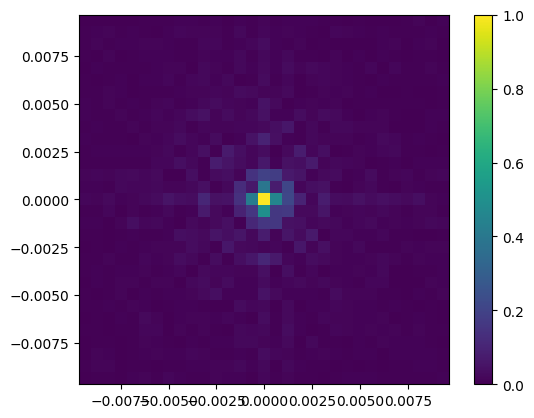

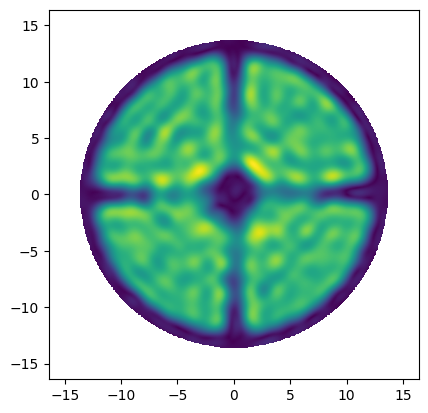

<xarray.Dataset>
Dimensions:          (time: 1, chan: 1, pol: 4, u_prime: 442, v_prime: 442,
                      u: 529, v: 529, l: 31, m: 31, ddi: 1)
Coordinates:
  * chan             (chan) float64 1.417e+10
  * ddi              (ddi) <U5 'ddi_0'
  * l                (l) float64 0.009664 0.009019 ... -0.009019 -0.009664
  * m                (m) float64 -0.009664 -0.009019 ... 0.009019 0.009664
  * pol              (pol) <U1 'I' 'Q' 'U' 'V'
  * u                (u) float64 774.6 771.7 768.8 ... -768.8 -771.7 -774.6
  * u_prime          (u_prime) float64 648.5 645.5 642.6 ... -642.6 -645.5
  * v                (v) float64 -774.6 -771.7 -768.8 ... 768.8 771.7 774.6
  * v_prime          (v_prime) float64 -648.5 -645.5 -642.6 ... 642.6 645.5
Dimensions without coordinates: time
Data variables:
    AMPLITUDE        (time, chan, pol, u_prime, v_prime) float64 dask.array<chunksize=(1, 1, 1, 221, 221), meta=np.ndarray>
    APERTURE         (time, chan, pol, u, v) complex128 dask.array<chunksize=(1, 1, 1, 133, 265), meta=np.ndarray>
    BEAM             (time, chan, pol, l, m) complex128 dask.array<chunksize=(1, 1, 4, 31, 31), meta=np.ndarray>
    CORRECTED_PHASE  (time, chan, pol, u_prime, v_prime) float64 dask.array<chunksize=(1, 1, 1, 221, 221), meta=np.ndarray>
Attributes:
    ant_id:               ant_ea25
    ant_name:             ea25
    aperture_resolution:  [1.3905320799957253, 1.3905320799957253]
    ddi:                  ddi_0
    telescope_name:       EVLA
    time_centroid:        5169758956.499999

In [8]:
import xarray as xr
import matplotlib.pyplot as plt
import scipy
import matplotlib.patches as patches

from scipy import constants

from astrohack.dio import open_image

beforeimage = resultsfolder+'/before.split.image.zarr'
afterimage = resultsfolder+'/after.split.image.zarr'

plt.close('all')

chan = 0

ds = open_image("results/before.split.image.zarr")['ant_ea25']['ddi_0']

wavelength = scipy.constants.speed_of_light/ds.chan.values[chan]
l = ds.l.values
m = ds.m.values
u = ds.u.values*wavelength
v = ds.v.values*wavelength

print(u.min(),u.max())

plt.figure()
plt.imshow(np.abs(ds.BEAM[0,chan,0,:,:]),extent=[l.min(), l.max(), m.min(), m.max()])
plt.colorbar()
plt.show()

circle = patches.Circle((0,0), 12.5, fill=False, color='white', alpha=0.7, linewidth=2)

fig, ax =plt.subplots()
plt.imshow(np.abs(ds.APERTURE[0,chan,0,:,:]),extent=[u.min(), u.max(), v.min(), v.max()])

plt.show()

ds

In [9]:
from astrohack.panel import panel

panel_model = 'rigid'

before_panel = panel(
    image_name=beforeimage, 
    panel_model=panel_model,
    parallel=True,
    overwrite=True
)
after_panel = panel(
    image_name=afterimage, 
    panel_model=panel_model,
    parallel=True,
    overwrite=True
)

2023-05-30 09:42:22,099 - INFO     - astrohack - (_check_parms.py:130) - [panel]: Setting default panel_name to results/before.split.panel.zarr.
2023-05-30 09:42:22,101 - INFO     - astrohack - (_check_parms.py:130) - [panel]: Setting default ant to all.
2023-05-30 09:42:22,102 - INFO     - astrohack - (_check_parms.py:130) - [panel]: Setting default ddi to all.
2023-05-30 09:42:22,127 - WARNING  - astrohack - (_dio.py:34) - [panel]: results/before.split.panel.zarr will be overwritten.
2023-05-30 09:42:23,881 - INFO     - astrohack - (panel.py:111) - [panel]: Finished processing
2023-05-30 09:42:23,913 - INFO     - astrohack - (_check_parms.py:130) - [panel]: Setting default panel_name to results/after.split.panel.zarr.
2023-05-30 09:42:23,914 - INFO     - astrohack - (_check_parms.py:130) - [panel]: Setting default ant to all.
2023-05-30 09:42:23,915 - INFO     - astrohack - (_check_parms.py:130) - [panel]: Setting default ddi to all.
2023-05-30 09:42:23,956 - WARNING  - astrohack - (

In [10]:
import numpy as np
from astrohack.dio import open_panel

def relative_difference(mean, expected):  
    return 2*np.abs(mean - expected)/(abs(mean) + abs(expected))

def verify_panel_shifts(
    panel_list=['3-4', '5-27', '5-37', '5-38'], 
    expected_shift=np.array([-100, 75, 0, 150]),
    ref_mean_shift = np.array([-112.2325, 73.225, -1.455, 139.04  ]),
    antenna='ant_ea25',
    ddi='ddi_0'
):
    
    M_TO_MILS = 39370.1
    
    before_mds = open_panel('results/before.split.panel.zarr')
    after_mds = open_panel('results/after.split.panel.zarr')
    
    before_shift = before_mds[antenna][ddi].sel(labels=panel_list).PANEL_SCREWS.values*M_TO_MILS
    after_shift = after_mds[antenna][ddi].sel(labels=panel_list).PANEL_SCREWS.values*M_TO_MILS
    
    difference = after_shift - before_shift
    
    mean_shift = np.mean(difference, axis=1)
    
    delta_mean_shift = np.abs(mean_shift - expected_shift)
    delta_ref_shift = np.abs(ref_mean_shift - expected_shift)
        
    delta_shift = delta_mean_shift - delta_ref_shift  # New corrections - old corrections --> delta if delta < 0 ==> we improved.
    relative_shift = relative_difference(delta_mean_shift, delta_ref_shift)
       
    if np.any(relative_shift > 1e-6): 
        print("There were changes!")
        for i, delta in enumerate(delta_shift):
            if delta < 0:
                print("{panel}, improved by {delta} mils".format(panel=panel_list[i], delta=delta))
            else:
                print("{panel}, got worse by {delta} mils".format(panel=panel_list[i], delta=delta))

In [11]:
verify_panel_shifts()

There were changes!
3-4, improved by -0.054609669332393196 mils
5-27, improved by -0.0011928630933937256 mils
5-37, got worse by 0.08166467580627934 mils
5-38, got worse by 0.04382912986815768 mils
